# import packages

In [5]:
%matplotlib inline 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import ttest_ind

# import bond data provided by Harris County

In [7]:
path = './fworrrevisedwheeler'

file_list = ['/DATA - Wheeler (2017 approvals - felony).xlsx',
'/DATA - Wheeler (2018 approvals - felony).xlsx']
df_list = []
for file in file_list: 
    for i in range(5):
        df_iter = pd.read_excel(path+file, sheet_name=i)
        df_list.append(df_iter)
    approvals = pd.concat(df_list)
    approvals['CaseNumber'] = approvals['CaseNumber'].astype(str)

file_list = ['/DATA - Wheeler (2017 forfeitures - felony).xlsx',
'/DATA - Wheeler (2018 forfeitures - felony).xlsx']
df_list = []
for file in file_list: 
    for i in range(5):
        df_iter = pd.read_excel(path+file, sheet_name=i)
        df_list.append(df_iter)
        forfeitures = pd.concat(df_list)
    forfeitures['CaseNumber'] = forfeitures['CaseNumber'].str[:-1]
    forfeitures['CaseNumber'] = forfeitures['CaseNumber'] + '0'
    forfeitures['ForfDate'] = forfeitures['ForfDate'].astype(int)
    forfeitures['ForfDate'] = pd.to_datetime(forfeitures['ForfDate'], format='%Y%m%d')


# determine who forfeitted

In [8]:
df = approvals.merge(forfeitures, on='CaseNumber', how='left', suffixes=('_app', '_for'))

df = df.dropna(subset=['BondAmtMade'])

df['forfeit'] = np.where(df['ForfDate'] > df['DateApproved'], 1, 0)

# bin CodeDesc into Code groups

In [9]:
conditions = [
    df['CodeDesc'].isin(['SURETY','APPEAL']),
    df['CodeDesc'].isin(['CASH', 'CASH APPEAL']),
    df['CodeDesc']=='PERSONAL',
    df['CodeDesc']=='PERSONAL PTR'
]
choices = ['Surety', 'Cash', 'Personal', 'PTR']
df['Code'] = np.select(conditions, choices, default=df['CodeDesc'])

In [10]:
df['Code'].value_counts()

Surety                         31406
PTR                             6044
EARLY PRESENTMENT - PTRL         809
Cash                             478
Personal                          24
SB7 - PTRL                        23
UNSECURED BAIL BOND-SHERIFF        3
Name: Code, dtype: int64

In [11]:
df = df.loc[df['Code'].isin(['Surety', 'Cash', 'Personal', 'PTR'])]

# calculate bond amount summary statistics by Code and forfeit status

In [12]:
df.groupby(['Code','forfeit'])['BondAmtMade'].describe()

count          mean           std     min     25%  \
Code     forfeit                                                        
Cash     0          421.0   5445.011876  10388.144516   150.0  1000.0   
         1           57.0   3140.350877   4305.057642  1000.0  1500.0   
PTR      0         5321.0   4759.189062   7753.537244    45.0  1500.0   
         1          723.0   4860.995851  15060.647483   500.0  1500.0   
Personal 0           21.0  21357.142857  23383.831410  1500.0  5000.0   
         1            3.0   3833.333333   2020.725942  1500.0  3250.0   
Surety   0        27746.0  17709.983709  22812.887494   100.0  5000.0   
         1         3660.0  15059.426230  19315.212458   500.0  3000.0   

                      50%      75%       max  
Code     forfeit                              
Cash     0         2000.0   5000.0   75000.0  
         1         2000.0   2500.0   30000.0  
PTR      0         2000.0   5000.0  175000.0  
         1         2000.0   5000.0  300000.0  
Personal 0        10000.0  40000.0   80000.0  
         1         5000.0   5000.0    5000.0  
Surety   0        10000.0  25000.0  500000.0  
         1        10000.0  20000.0  250000.0

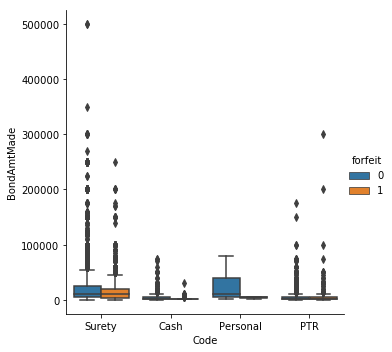

In [13]:
sns.catplot(x="Code", y="BondAmtMade", hue='forfeit', kind="box", data=df)

# test whether bond amounts are significantly different

In [84]:
df_list = []
for i in df['Code'].unique().tolist():
    bond_forf = df.loc[(df['Code']==i) & (df['forfeit']==1)]['BondAmtMade']
    bond_no_forf = df.loc[(df['Code']==i) & (df['forfeit']==0)]['BondAmtMade']
    t, p = ttest_ind(bond_forf, bond_no_forf, equal_var=False)
    tr = pd.DataFrame(data=[i], columns=['code'])
    tr['t-stat']=round(t,3)
    tr['p-value']=round(p,3)
    df_list.append(tr)
tr = pd.concat(df_list)
tr = tr.set_index('code')
tr

,t-stat,p-value
code,,
Surety,-7.630,0.000
Cash,-3.022,0.003
Personal,-3.348,0.003
PTR,0.179,0.858
